**Обратная связь по проекту**   
Шинкаренко Яна   
Telegram: [тык](https://t.me/sirena0789)

# Описание проекта

Компания онлайн-сервис с высоким уровнем входящего трафика имеет специализированный отдел безопасности, который занимается фильтрацией и анализом трафика. Сотрудники этого отдела обратились за помощью в автоматизации выявления аномального и злонамеренного трафика. Ваша задача - разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный, включая следующие типы атак: DDoS, SQL-инъекции, брутфорс, вредоносные программы и т.д.

<a id='step2'></a>
## План работы

1. Знакомство с данными. Необходимо выгрузить и проверить типы данных, наличие пропусков и дубликатов. 
2. Предобработка данных. На этом этапе нужно подготовить данные.
3. Исследовательский анализ данных. Необходимо визуализировать данные, исследовать корреляцию между признаками и избавиться от выбросов. 
4. Подготовить данные для обучения модели. Удалить,если есть, ненужные столбцы, разделить данные на выборки, для линейных моделей масштабировать числовые признаки. 
5. Подбор гиперпараметров и обучение моделей. 
6. Тестирование наилучшей модели. 
7. Вывод. 

## Цель работы
- Разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный. При этом модель должна работать максимально качественно, так как цена ошибки может быть очень высока.
- Оценить качество модели по различным метрикам классификации: precision, recall, f1_score, accuracy.
- Деплой: разработать REST API сервис, который будет принимать на вход данные трафика и возвращать класс этого трафика.

<a id='step4'></a>
# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from feature_selector import FeatureSelector
from catboost import CatBoostClassifier
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import warnings
warnings.simplefilter("ignore")

<a id='step5'></a>
# Знакомство с данными

<a id='step5.1'></a>
## Вспомогательные функции

In [2]:
def visualization_of_features(df):

    features = list(df.columns)
    f_size = (10, 200)
    plt.figure(figsize=f_size)

    for i, feature in enumerate(features):
        plt.subplot(int(np.ceil(len(features) / 2)), 2, i+1)
        plt.subplots_adjust(wspace=0.3, hspace=0.7)
        df[feature].hist(color='pink')
        plt.title(feature)
        plt.xlabel("Значение признака")
        plt.ylabel("Количество")

    return

In [3]:
def data_information(df):

    display(df.head(5))

    print('Информация о полях: \n')
    df.info()
    print('\n')

    print('Размер фрейма:', df.shape)

    print('Количество дубликатов:', df.duplicated().sum())
    print('Доля дубликатов: ' +
          str(int(100 * df.duplicated().sum() / df.shape[0])) + '%')

    print('Количество пропусков:', df.isnull().sum().sum())

    print('Описательная статистика: \n')
    display(df.describe())

    return

In [4]:
def missing_values(df):

    values = df.isnull().sum()
    values_percent = 100 * df.isnull().sum() / len(df)
    values_table = pd.concat([values, values_percent], axis=1)

    values_table = values_table.rename(
        columns={0: 'Missing values', 1: '% of total values'})

    values_table = values_table[values_table.iloc[:, 1] != 0].sort_values(
        '% of total values', ascending=False).round(1)

    print(str(values_table.shape[0]) +
          " columns have missing values.")

    return values_table

In [5]:
def finding_null_columns(df):

    name_of_null = []

    for col in df.columns:
        if df[col].values.sum() == 0:
            name_of_null.append(col)

    return name_of_null

## Загрузка данных

In [32]:
try:
    df = pd.read_csv(
        "/Users/sirena0789/Desktop/TrafficСlassification/network_traffic_data.csv", index_col=0)
except:
    df = pd.read_csv(
        "/content/drive/MyDrive/data/network_traffic_data.csv", index_col=0)

In [33]:
data_information(df)

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
Destination Port,,,,,,,,,,,,,,,,,,,,,
80,5480074,3,1,12,0,6,0,4.000,3.465,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
443,711977,9,10,703,3950,267,0,78.100,103.300,1448,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
53,153398,2,2,80,224,40,40,40.000,0.000,112,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
53,57660,1,1,46,128,46,46,46.000,0.000,128,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
8446,767,3,1,43,6,31,6,14.336,14.440,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


Информация о полях: 

<class 'pandas.core.frame.DataFrame'>
Index: 539616 entries, 80 to 80
Data columns (total 78 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Flow Duration                539616 non-null  int64  
 1    Total Fwd Packets            539616 non-null  int64  
 2    Total Backward Packets       539616 non-null  int64  
 3   Total Length of Fwd Packets   539616 non-null  int64  
 4    Total Length of Bwd Packets  539616 non-null  int64  
 5    Fwd Packet Length Max        539616 non-null  int64  
 6    Fwd Packet Length Min        539616 non-null  int64  
 7    Fwd Packet Length Mean       539616 non-null  float64
 8    Fwd Packet Length Std        539616 non-null  float64
 9   Bwd Packet Length Max         539616 non-null  int64  
 10   Bwd Packet Length Min        539616 non-null  int64  
 11   Bwd Packet Length Mean       539616 non-null  float64
 12   Bwd Packet Length Std        

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,5.396160e+05,539616.000000,539616.000000,5.396160e+05,5.396160e+05,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,...,539616.000000,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05
mean,2.106693e+07,6.119972,5.985495,4.082371e+02,7.999779e+03,169.449966,11.855382,44.681011,59.525095,1675.074384,...,2.946516,-2.429314e+03,1.154984e+05,4.037570e+04,1.672882e+05,8.983017e+04,1.610155e+07,9.585649e+05,1.687227e+07,1.539150e+07
std,3.812172e+07,345.109317,463.490949,7.478351e+03,1.014442e+06,560.533869,60.961661,150.873880,217.729412,2843.534429,...,267.510434,1.052329e+06,7.787530e+05,4.347032e+05,1.059626e+06,7.099710e+05,3.315463e+07,6.461275e+06,3.403851e+07,3.295695e+07
min,-1.200000e+01,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.300000e+01,1.000000,1.000000,2.000000e+00,0.000000e+00,2.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.973900e+04,2.000000,2.000000,4.400000e+01,1.050000e+02,23.000000,0.000000,11.220000,0.000000,60.000000,...,1.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.064030e+07,6.000000,5.000000,3.200000e+02,8.216250e+03,272.000000,6.000000,48.560000,91.700000,2796.000000,...,2.000000,3.200000e+01,6.000000e+00,0.000000e+00,6.000000e+00,5.000000e+00,7.125041e+06,0.000000e+00,7.143036e+06,6.028677e+06
max,1.200000e+08,200755.000000,270686.000000,2.866110e+06,5.910000e+08,24820.000000,2065.000000,5940.000000,7050.000000,17376.000000,...,192491.000000,1.380000e+02,1.020000e+08,6.350000e+07,1.020000e+08,1.020000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


# Предобработка данных

В столбцах Flow Bytes/s и  Flow Packets/s присутствуют inf значения. Уберем их.

In [34]:
max_value = np.nanmax(df['Flow Bytes/s'][df['Flow Bytes/s'] != np.inf])
df['Flow Bytes/s'].replace([np.inf, -np.inf],
                           max_value, inplace=True)

max_value = np.nanmax(df[' Flow Packets/s'][df[' Flow Packets/s'] != np.inf])
df[' Flow Packets/s'].replace([np.inf, -np.inf],
                              max_value, inplace=True)

В данных присутствуют пропуски. Определим поля и долю пропущенных значений. 

In [35]:
missing_values(df)

1 columns have missing values.


,Missing values,% of total values
Flow Bytes/s,488,0.1


От такого небольшого процента можно избавиться.

In [36]:
df = df.dropna()

Так же удалим дубликаты строк, несмотря на большой обьем их доли.

In [37]:
df = df.drop_duplicates()

Разобьем данные на признаки и целевой признак для упрощения анализа.

In [38]:
features = df.drop(columns=['Label'])
target = df['Label']

Визуализируем признаки.

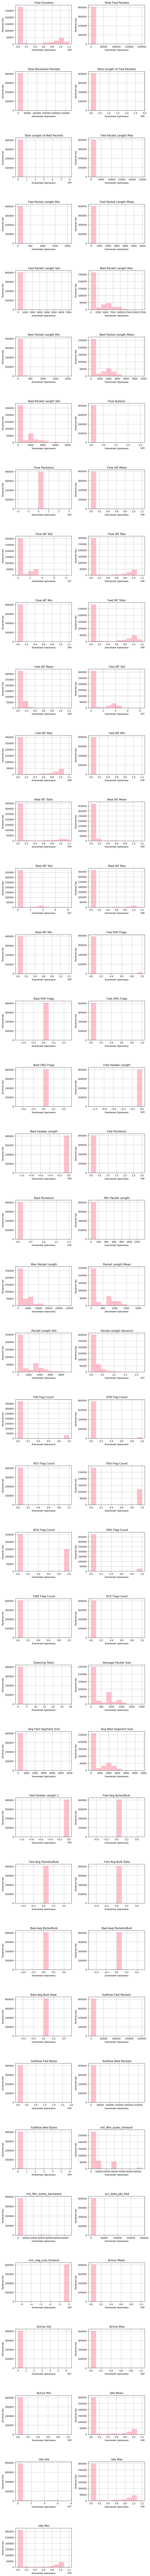

In [39]:
visualization_of_features(features)

Визуализируем целевой признак.

Text(0, 0.5, 'Количество')

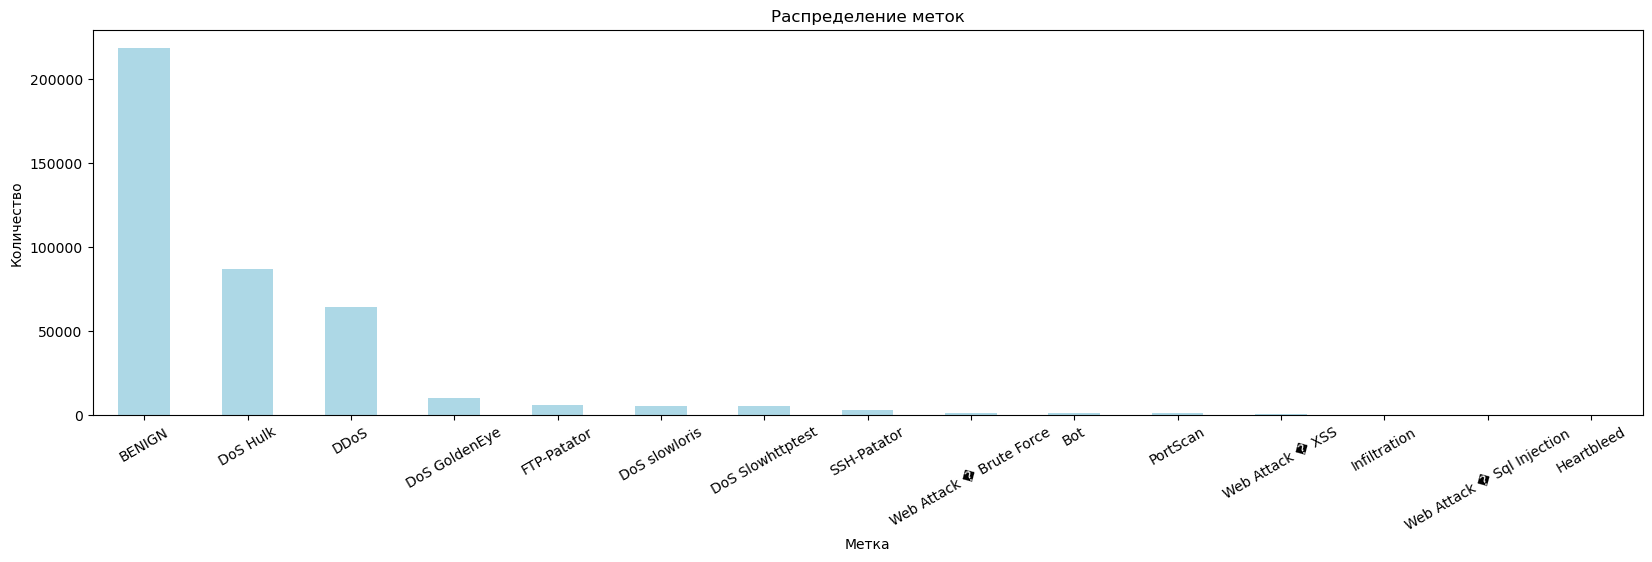

In [40]:
target.value_counts().plot(kind='bar', 
                                 figsize=(20, 5), title='Распределение меток', 
                                 color='lightblue')
plt.xlabel("Метка")
plt.xticks(rotation=30)
plt.ylabel("Количество")

В данных присутствуют поля с нулевыми значениями. Их можно удалить, так как они не несут нагрузки на модель.

Определим имена нулевых полей.

In [41]:
finding_null_columns(features)

[' Bwd PSH Flags',
 ' Bwd URG Flags',
 'Fwd Avg Bytes/Bulk',
 ' Fwd Avg Packets/Bulk',
 ' Fwd Avg Bulk Rate',
 ' Bwd Avg Bytes/Bulk',
 ' Bwd Avg Packets/Bulk',
 'Bwd Avg Bulk Rate']

Удаляем эти поля.

In [42]:
features = features.drop(columns=finding_null_columns(features))

# Разведочный анализ данных

Воспользуемся библиотекой FeatureSelector для предварительного анализа.

Создаем экземпляр обьекта.

In [43]:
fs = FeatureSelector(data = features, labels = target)

Проверим присутствуют ли поля с одним уникальным значением.

In [44]:
fs.identify_single_unique()

0 features with a single unique value.



Взглянем на количество уникальных значений в столбцах.

In [45]:
fs.unique_stats.sample(69).sort_values(by='nunique')

,nunique
Fwd URG Flags,2
CWE Flag Count,2
SYN Flag Count,2
ECE Flag Count,2
Fwd PSH Flags,2
...,...
Flow Duration,280102
Flow IAT Mean,281123
Fwd Packets/s,289190
Flow Packets/s,301149


Определим поля с корреляцией выше заданного порогового значения (0.95).

In [46]:
fs.identify_collinear(correlation_threshold=0.95)

27 features with a correlation magnitude greater than 0.95.



Посмотрм на названия данных полей.

In [47]:
correlated_features = fs.ops['collinear']
correlated_features[:10]

[' Total Backward Packets',
 ' Total Length of Bwd Packets',
 ' Fwd Packet Length Std',
 ' Bwd Packet Length Mean',
 ' Bwd Packet Length Std',
 ' Flow IAT Max',
 'Fwd IAT Total',
 ' Fwd IAT Max',
 ' Bwd Header Length',
 ' Max Packet Length']

Построим тепловую карту данных полей.

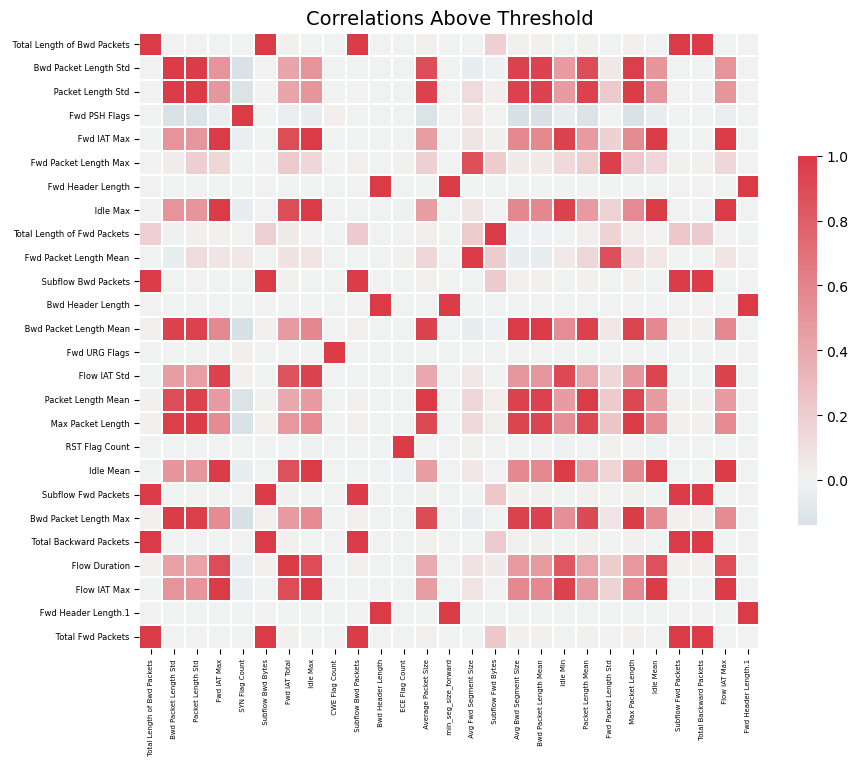

In [48]:
"""
Notes
            - Not all of the plotted correlations are above the threshold because this plots
            all the variables that have been idenfitied as having even one correlation above the threshold
            - The features on the x-axis are those that will be removed. The features on the y-axis
            are the correlated features with those on the x-axis
        
        Code adapted from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
"""
fs.plot_collinear()

Так же взглянем на карту всех признаков.

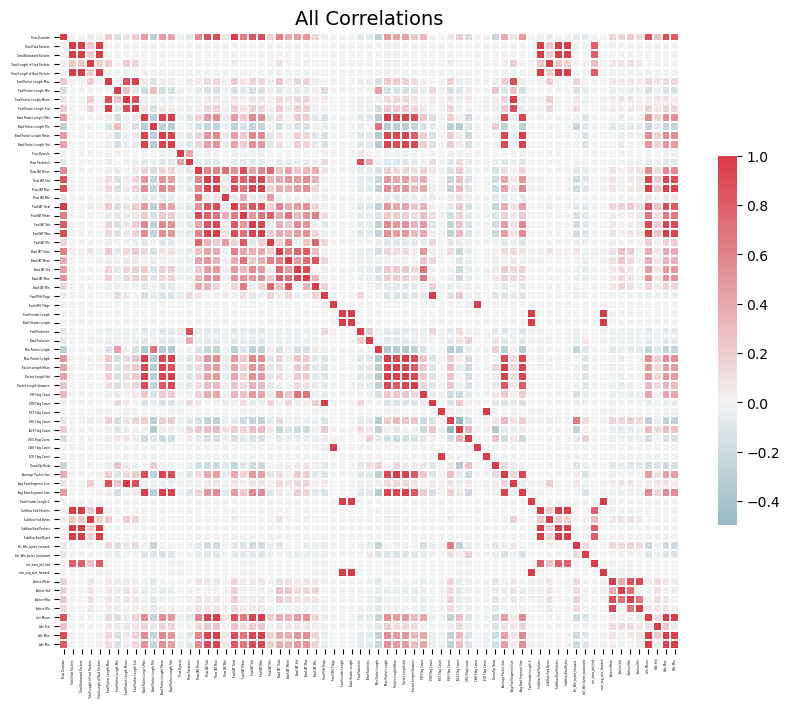

In [49]:
fs.plot_collinear(plot_all=True)

Удаляем сильнокоррелирующие признаки.

In [50]:
features = fs.remove(methods=['collinear'])

Removed 27 features.


# Машинное обучение

## Подготовка данных к обучению

Разделим выборки на тестовую и тренировочную

In [51]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.2, 
                                                                            random_state=89) 

Пропишем пайплайн для модели

In [59]:
pipe = Pipeline(
    [('preprocess', StandardScaler()),
     ('estimator', CatBoostClassifier(
        loss_function='MultiClass', eval_metric='Accuracy'))], verbose=False
)

## Обучение модели

Предоставиим модели выбор между несколькими гипрепараметрами и обучим модель

In [61]:
param = {
    'estimator__iterations': [10, 50, 500],
    'estimator__learning_rate': [0.1, 0.01]
}

model = GridSearchCV(estimator=pipe, param_grid=param,
                     cv=2, scoring='accuracy', verbose=0)
model.fit(features_train, target_train)
target_predict = model.predict(features_train)

0:	learn: 0.9174985	total: 143ms	remaining: 1.29s
1:	learn: 0.9271167	total: 287ms	remaining: 1.15s
2:	learn: 0.9311973	total: 434ms	remaining: 1.01s
3:	learn: 0.9363151	total: 582ms	remaining: 873ms
4:	learn: 0.9392660	total: 732ms	remaining: 732ms
5:	learn: 0.9417909	total: 877ms	remaining: 584ms
6:	learn: 0.9425502	total: 1.02s	remaining: 438ms
7:	learn: 0.9455011	total: 1.17s	remaining: 292ms
8:	learn: 0.9466494	total: 1.32s	remaining: 147ms
9:	learn: 0.9501435	total: 1.47s	remaining: 0us
0:	learn: 0.9240490	total: 150ms	remaining: 1.35s
1:	learn: 0.9278827	total: 294ms	remaining: 1.17s
2:	learn: 0.9331671	total: 445ms	remaining: 1.04s
3:	learn: 0.9369143	total: 591ms	remaining: 887ms
4:	learn: 0.9377971	total: 737ms	remaining: 737ms
5:	learn: 0.9401368	total: 885ms	remaining: 590ms
6:	learn: 0.9416925	total: 1.03s	remaining: 441ms
7:	learn: 0.9445878	total: 1.17s	remaining: 293ms
8:	learn: 0.9452545	total: 1.32s	remaining: 146ms
9:	learn: 0.9536133	total: 1.46s	remaining: 0us
0:	l

24:	learn: 0.9426120	total: 3.78s	remaining: 3.78s
25:	learn: 0.9424762	total: 3.93s	remaining: 3.62s
26:	learn: 0.9426367	total: 4.07s	remaining: 3.47s
27:	learn: 0.9425564	total: 4.22s	remaining: 3.31s
28:	learn: 0.9426799	total: 4.36s	remaining: 3.16s
29:	learn: 0.9425317	total: 4.5s	remaining: 3s
30:	learn: 0.9425255	total: 4.65s	remaining: 2.85s
31:	learn: 0.9425379	total: 4.79s	remaining: 2.69s
32:	learn: 0.9436800	total: 4.94s	remaining: 2.54s
33:	learn: 0.9442171	total: 5.08s	remaining: 2.39s
34:	learn: 0.9427848	total: 5.23s	remaining: 2.24s
35:	learn: 0.9432108	total: 5.38s	remaining: 2.09s
36:	learn: 0.9430565	total: 5.52s	remaining: 1.94s
37:	learn: 0.9441306	total: 5.66s	remaining: 1.79s
38:	learn: 0.9442973	total: 5.81s	remaining: 1.64s
39:	learn: 0.9437108	total: 5.96s	remaining: 1.49s
40:	learn: 0.9450073	total: 6.1s	remaining: 1.34s
41:	learn: 0.9437047	total: 6.24s	remaining: 1.19s
42:	learn: 0.9444023	total: 6.38s	remaining: 1.04s
43:	learn: 0.9455876	total: 6.53s	re

86:	learn: 0.9925672	total: 13.7s	remaining: 1m 5s
87:	learn: 0.9925796	total: 13.9s	remaining: 1m 5s
88:	learn: 0.9925178	total: 14.1s	remaining: 1m 4s
89:	learn: 0.9925919	total: 14.2s	remaining: 1m 4s
90:	learn: 0.9926598	total: 14.4s	remaining: 1m 4s
91:	learn: 0.9926783	total: 14.6s	remaining: 1m 4s
92:	learn: 0.9926845	total: 14.7s	remaining: 1m 4s
93:	learn: 0.9927462	total: 14.9s	remaining: 1m 4s
94:	learn: 0.9927462	total: 15s	remaining: 1m 4s
95:	learn: 0.9928141	total: 15.2s	remaining: 1m 3s
96:	learn: 0.9927895	total: 15.4s	remaining: 1m 3s
97:	learn: 0.9927956	total: 15.5s	remaining: 1m 3s
98:	learn: 0.9929500	total: 15.7s	remaining: 1m 3s
99:	learn: 0.9929808	total: 15.9s	remaining: 1m 3s
100:	learn: 0.9930487	total: 16s	remaining: 1m 3s
101:	learn: 0.9931784	total: 16.2s	remaining: 1m 3s
102:	learn: 0.9932092	total: 16.3s	remaining: 1m 2s
103:	learn: 0.9932833	total: 16.5s	remaining: 1m 2s
104:	learn: 0.9933698	total: 16.7s	remaining: 1m 2s
105:	learn: 0.9934624	total: 1

247:	learn: 0.9958329	total: 41.4s	remaining: 42.1s
248:	learn: 0.9958391	total: 41.5s	remaining: 41.9s
249:	learn: 0.9958391	total: 41.7s	remaining: 41.7s
250:	learn: 0.9958391	total: 41.9s	remaining: 41.5s
251:	learn: 0.9958391	total: 42s	remaining: 41.4s
252:	learn: 0.9958391	total: 42.2s	remaining: 41.2s
253:	learn: 0.9958576	total: 42.4s	remaining: 41.1s
254:	learn: 0.9958576	total: 42.6s	remaining: 40.9s
255:	learn: 0.9958515	total: 42.7s	remaining: 40.7s
256:	learn: 0.9958453	total: 42.9s	remaining: 40.6s
257:	learn: 0.9958638	total: 43.1s	remaining: 40.4s
258:	learn: 0.9958576	total: 43.2s	remaining: 40.2s
259:	learn: 0.9958947	total: 43.4s	remaining: 40.1s
260:	learn: 0.9958885	total: 43.6s	remaining: 39.9s
261:	learn: 0.9958947	total: 43.7s	remaining: 39.7s
262:	learn: 0.9958576	total: 43.9s	remaining: 39.6s
263:	learn: 0.9959502	total: 44.1s	remaining: 39.4s
264:	learn: 0.9959564	total: 44.2s	remaining: 39.2s
265:	learn: 0.9959502	total: 44.4s	remaining: 39s
266:	learn: 0.99

407:	learn: 0.9968392	total: 1m 8s	remaining: 15.4s
408:	learn: 0.9968392	total: 1m 8s	remaining: 15.3s
409:	learn: 0.9968701	total: 1m 8s	remaining: 15.1s
410:	learn: 0.9968701	total: 1m 8s	remaining: 14.9s
411:	learn: 0.9968763	total: 1m 9s	remaining: 14.8s
412:	learn: 0.9968701	total: 1m 9s	remaining: 14.6s
413:	learn: 0.9968948	total: 1m 9s	remaining: 14.4s
414:	learn: 0.9969009	total: 1m 9s	remaining: 14.2s
415:	learn: 0.9969071	total: 1m 9s	remaining: 14.1s
416:	learn: 0.9969009	total: 1m 9s	remaining: 13.9s
417:	learn: 0.9969009	total: 1m 10s	remaining: 13.7s
418:	learn: 0.9968948	total: 1m 10s	remaining: 13.6s
419:	learn: 0.9969318	total: 1m 10s	remaining: 13.4s
420:	learn: 0.9969442	total: 1m 10s	remaining: 13.2s
421:	learn: 0.9969503	total: 1m 10s	remaining: 13.1s
422:	learn: 0.9969442	total: 1m 10s	remaining: 12.9s
423:	learn: 0.9969380	total: 1m 11s	remaining: 12.7s
424:	learn: 0.9969380	total: 1m 11s	remaining: 12.6s
425:	learn: 0.9969503	total: 1m 11s	remaining: 12.4s
426

66:	learn: 0.9910301	total: 10.6s	remaining: 1m 8s
67:	learn: 0.9910918	total: 10.7s	remaining: 1m 8s
68:	learn: 0.9911536	total: 10.9s	remaining: 1m 8s
69:	learn: 0.9911906	total: 11.1s	remaining: 1m 7s
70:	learn: 0.9912029	total: 11.2s	remaining: 1m 7s
71:	learn: 0.9912585	total: 11.4s	remaining: 1m 7s
72:	learn: 0.9912709	total: 11.6s	remaining: 1m 7s
73:	learn: 0.9914561	total: 11.7s	remaining: 1m 7s
74:	learn: 0.9914684	total: 11.9s	remaining: 1m 7s
75:	learn: 0.9916413	total: 12.1s	remaining: 1m 7s
76:	learn: 0.9916413	total: 12.2s	remaining: 1m 7s
77:	learn: 0.9916598	total: 12.4s	remaining: 1m 7s
78:	learn: 0.9917771	total: 12.6s	remaining: 1m 6s
79:	learn: 0.9918018	total: 12.7s	remaining: 1m 6s
80:	learn: 0.9918326	total: 12.9s	remaining: 1m 6s
81:	learn: 0.9918450	total: 13.1s	remaining: 1m 6s
82:	learn: 0.9924191	total: 13.2s	remaining: 1m 6s
83:	learn: 0.9924500	total: 13.4s	remaining: 1m 6s
84:	learn: 0.9925796	total: 13.6s	remaining: 1m 6s
85:	learn: 0.9925796	total: 13.

227:	learn: 0.9957342	total: 37.4s	remaining: 44.6s
228:	learn: 0.9957589	total: 37.6s	remaining: 44.5s
229:	learn: 0.9957836	total: 37.7s	remaining: 44.3s
230:	learn: 0.9957527	total: 37.9s	remaining: 44.1s
231:	learn: 0.9957589	total: 38.1s	remaining: 44s
232:	learn: 0.9957589	total: 38.2s	remaining: 43.8s
233:	learn: 0.9957712	total: 38.4s	remaining: 43.6s
234:	learn: 0.9959194	total: 38.5s	remaining: 43.5s
235:	learn: 0.9959564	total: 38.7s	remaining: 43.3s
236:	learn: 0.9959935	total: 38.8s	remaining: 43.1s
237:	learn: 0.9960243	total: 39s	remaining: 42.9s
238:	learn: 0.9960243	total: 39.2s	remaining: 42.8s
239:	learn: 0.9960058	total: 39.3s	remaining: 42.6s
240:	learn: 0.9960799	total: 39.5s	remaining: 42.5s
241:	learn: 0.9960799	total: 39.7s	remaining: 42.3s
242:	learn: 0.9960799	total: 39.8s	remaining: 42.1s
243:	learn: 0.9961169	total: 40s	remaining: 42s
244:	learn: 0.9961108	total: 40.2s	remaining: 41.8s
245:	learn: 0.9961046	total: 40.4s	remaining: 41.7s
246:	learn: 0.996086

388:	learn: 0.9968763	total: 1m 3s	remaining: 18.3s
389:	learn: 0.9968824	total: 1m 4s	remaining: 18.1s
390:	learn: 0.9968824	total: 1m 4s	remaining: 17.9s
391:	learn: 0.9968824	total: 1m 4s	remaining: 17.8s
392:	learn: 0.9968824	total: 1m 4s	remaining: 17.6s
393:	learn: 0.9968763	total: 1m 4s	remaining: 17.4s
394:	learn: 0.9968763	total: 1m 5s	remaining: 17.3s
395:	learn: 0.9968701	total: 1m 5s	remaining: 17.1s
396:	learn: 0.9968824	total: 1m 5s	remaining: 17s
397:	learn: 0.9968824	total: 1m 5s	remaining: 16.8s
398:	learn: 0.9969010	total: 1m 5s	remaining: 16.6s
399:	learn: 0.9969010	total: 1m 5s	remaining: 16.5s
400:	learn: 0.9969010	total: 1m 5s	remaining: 16.3s
401:	learn: 0.9969010	total: 1m 6s	remaining: 16.1s
402:	learn: 0.9969442	total: 1m 6s	remaining: 16s
403:	learn: 0.9969504	total: 1m 6s	remaining: 15.8s
404:	learn: 0.9969504	total: 1m 6s	remaining: 15.6s
405:	learn: 0.9969504	total: 1m 6s	remaining: 15.5s
406:	learn: 0.9969565	total: 1m 6s	remaining: 15.3s
407:	learn: 0.99

46:	learn: 0.9458839	total: 6.86s	remaining: 1m 6s
47:	learn: 0.9459456	total: 7s	remaining: 1m 5s
48:	learn: 0.9460814	total: 7.15s	remaining: 1m 5s
49:	learn: 0.9457851	total: 7.29s	remaining: 1m 5s
50:	learn: 0.9459765	total: 7.45s	remaining: 1m 5s
51:	learn: 0.9461370	total: 7.6s	remaining: 1m 5s
52:	learn: 0.9462296	total: 7.74s	remaining: 1m 5s
53:	learn: 0.9463407	total: 7.89s	remaining: 1m 5s
54:	learn: 0.9465321	total: 8.03s	remaining: 1m 4s
55:	learn: 0.9466000	total: 8.18s	remaining: 1m 4s
56:	learn: 0.9466000	total: 8.32s	remaining: 1m 4s
57:	learn: 0.9464210	total: 8.47s	remaining: 1m 4s
58:	learn: 0.9463592	total: 8.62s	remaining: 1m 4s
59:	learn: 0.9462234	total: 8.76s	remaining: 1m 4s
60:	learn: 0.9461864	total: 8.91s	remaining: 1m 4s
61:	learn: 0.9462049	total: 9.05s	remaining: 1m 3s
62:	learn: 0.9461925	total: 9.2s	remaining: 1m 3s
63:	learn: 0.9461555	total: 9.34s	remaining: 1m 3s
64:	learn: 0.9462049	total: 9.49s	remaining: 1m 3s
65:	learn: 0.9466988	total: 9.63s	re

208:	learn: 0.9705775	total: 31.5s	remaining: 43.9s
209:	learn: 0.9706763	total: 31.7s	remaining: 43.7s
210:	learn: 0.9707010	total: 31.8s	remaining: 43.6s
211:	learn: 0.9708183	total: 32s	remaining: 43.4s
212:	learn: 0.9708492	total: 32.1s	remaining: 43.3s
213:	learn: 0.9708615	total: 32.3s	remaining: 43.2s
214:	learn: 0.9708677	total: 32.4s	remaining: 43s
215:	learn: 0.9708800	total: 32.6s	remaining: 42.9s
216:	learn: 0.9708862	total: 32.8s	remaining: 42.7s
217:	learn: 0.9709047	total: 32.9s	remaining: 42.6s
218:	learn: 0.9709294	total: 33.1s	remaining: 42.4s
219:	learn: 0.9709726	total: 33.2s	remaining: 42.3s
220:	learn: 0.9709911	total: 33.4s	remaining: 42.1s
221:	learn: 0.9710899	total: 33.5s	remaining: 42s
222:	learn: 0.9710344	total: 33.7s	remaining: 41.9s
223:	learn: 0.9710097	total: 33.9s	remaining: 41.7s
224:	learn: 0.9710097	total: 34s	remaining: 41.6s
225:	learn: 0.9710344	total: 34.2s	remaining: 41.4s
226:	learn: 0.9710590	total: 34.3s	remaining: 41.3s
227:	learn: 0.971225

368:	learn: 0.9830540	total: 56.9s	remaining: 20.2s
369:	learn: 0.9832083	total: 57s	remaining: 20s
370:	learn: 0.9832268	total: 57.2s	remaining: 19.9s
371:	learn: 0.9832145	total: 57.3s	remaining: 19.7s
372:	learn: 0.9834738	total: 57.5s	remaining: 19.6s
373:	learn: 0.9835293	total: 57.6s	remaining: 19.4s
374:	learn: 0.9835849	total: 57.8s	remaining: 19.3s
375:	learn: 0.9835911	total: 57.9s	remaining: 19.1s
376:	learn: 0.9836158	total: 58.1s	remaining: 19s
377:	learn: 0.9836405	total: 58.3s	remaining: 18.8s
378:	learn: 0.9836405	total: 58.4s	remaining: 18.6s
379:	learn: 0.9837516	total: 58.6s	remaining: 18.5s
380:	learn: 0.9837516	total: 58.8s	remaining: 18.4s
381:	learn: 0.9837516	total: 59s	remaining: 18.2s
382:	learn: 0.9837269	total: 59.1s	remaining: 18.1s
383:	learn: 0.9837516	total: 59.3s	remaining: 17.9s
384:	learn: 0.9837763	total: 59.4s	remaining: 17.8s
385:	learn: 0.9840973	total: 59.6s	remaining: 17.6s
386:	learn: 0.9843195	total: 59.7s	remaining: 17.4s
387:	learn: 0.984356

26:	learn: 0.9426864	total: 4.24s	remaining: 1m 14s
27:	learn: 0.9426494	total: 4.4s	remaining: 1m 14s
28:	learn: 0.9425938	total: 4.55s	remaining: 1m 13s
29:	learn: 0.9425012	total: 4.71s	remaining: 1m 13s
30:	learn: 0.9433346	total: 4.86s	remaining: 1m 13s
31:	learn: 0.9432544	total: 5.02s	remaining: 1m 13s
32:	learn: 0.9444829	total: 5.18s	remaining: 1m 13s
33:	learn: 0.9444705	total: 5.34s	remaining: 1m 13s
34:	learn: 0.9446681	total: 5.5s	remaining: 1m 13s
35:	learn: 0.9446742	total: 5.65s	remaining: 1m 12s
36:	learn: 0.9447854	total: 5.8s	remaining: 1m 12s
37:	learn: 0.9451619	total: 5.94s	remaining: 1m 12s
38:	learn: 0.9450693	total: 6.09s	remaining: 1m 12s
39:	learn: 0.9451187	total: 6.24s	remaining: 1m 11s
40:	learn: 0.9453780	total: 6.39s	remaining: 1m 11s
41:	learn: 0.9452422	total: 6.54s	remaining: 1m 11s
42:	learn: 0.9454150	total: 6.68s	remaining: 1m 11s
43:	learn: 0.9453410	total: 6.83s	remaining: 1m 10s
44:	learn: 0.9452854	total: 6.98s	remaining: 1m 10s
45:	learn: 0.94

186:	learn: 0.9701394	total: 27.9s	remaining: 46.7s
187:	learn: 0.9701579	total: 28s	remaining: 46.5s
188:	learn: 0.9701826	total: 28.2s	remaining: 46.4s
189:	learn: 0.9702073	total: 28.3s	remaining: 46.2s
190:	learn: 0.9701826	total: 28.5s	remaining: 46.1s
191:	learn: 0.9702258	total: 28.6s	remaining: 45.9s
192:	learn: 0.9702567	total: 28.8s	remaining: 45.8s
193:	learn: 0.9703678	total: 28.9s	remaining: 45.6s
194:	learn: 0.9703863	total: 29.1s	remaining: 45.4s
195:	learn: 0.9704048	total: 29.2s	remaining: 45.3s
196:	learn: 0.9704542	total: 29.3s	remaining: 45.1s
197:	learn: 0.9705283	total: 29.5s	remaining: 45s
198:	learn: 0.9705407	total: 29.6s	remaining: 44.8s
199:	learn: 0.9706024	total: 29.8s	remaining: 44.7s
200:	learn: 0.9705839	total: 29.9s	remaining: 44.5s
201:	learn: 0.9705839	total: 30.1s	remaining: 44.4s
202:	learn: 0.9705962	total: 30.2s	remaining: 44.2s
203:	learn: 0.9705839	total: 30.4s	remaining: 44.1s
204:	learn: 0.9706147	total: 30.5s	remaining: 43.9s
205:	learn: 0.97

346:	learn: 0.9809243	total: 51.7s	remaining: 22.8s
347:	learn: 0.9809305	total: 51.9s	remaining: 22.7s
348:	learn: 0.9809490	total: 52s	remaining: 22.5s
349:	learn: 0.9809922	total: 52.2s	remaining: 22.4s
350:	learn: 0.9810354	total: 52.4s	remaining: 22.2s
351:	learn: 0.9813070	total: 52.5s	remaining: 22.1s
352:	learn: 0.9810663	total: 52.7s	remaining: 21.9s
353:	learn: 0.9813255	total: 52.8s	remaining: 21.8s
354:	learn: 0.9813255	total: 53s	remaining: 21.6s
355:	learn: 0.9814058	total: 53.1s	remaining: 21.5s
356:	learn: 0.9813996	total: 53.3s	remaining: 21.3s
357:	learn: 0.9814490	total: 53.4s	remaining: 21.2s
358:	learn: 0.9814490	total: 53.6s	remaining: 21s
359:	learn: 0.9814552	total: 53.7s	remaining: 20.9s
360:	learn: 0.9814614	total: 53.9s	remaining: 20.7s
361:	learn: 0.9814552	total: 54s	remaining: 20.6s
362:	learn: 0.9816651	total: 54.2s	remaining: 20.4s
363:	learn: 0.9815293	total: 54.3s	remaining: 20.3s
364:	learn: 0.9818318	total: 54.5s	remaining: 20.2s
365:	learn: 0.981955

4:	learn: 0.9387661	total: 1.55s	remaining: 2m 33s
5:	learn: 0.9431431	total: 1.86s	remaining: 2m 33s
6:	learn: 0.9471280	total: 2.17s	remaining: 2m 33s
7:	learn: 0.9467792	total: 2.46s	remaining: 2m 31s
8:	learn: 0.9471589	total: 2.78s	remaining: 2m 31s
9:	learn: 0.9513537	total: 3.07s	remaining: 2m 30s
10:	learn: 0.9546657	total: 3.36s	remaining: 2m 29s
11:	learn: 0.9598081	total: 3.67s	remaining: 2m 29s
12:	learn: 0.9602927	total: 3.96s	remaining: 2m 28s
13:	learn: 0.9662686	total: 4.25s	remaining: 2m 27s
14:	learn: 0.9673211	total: 4.54s	remaining: 2m 26s
15:	learn: 0.9681823	total: 4.85s	remaining: 2m 26s
16:	learn: 0.9702041	total: 5.15s	remaining: 2m 26s
17:	learn: 0.9700930	total: 5.44s	remaining: 2m 25s
18:	learn: 0.9710344	total: 5.72s	remaining: 2m 24s
19:	learn: 0.9720407	total: 6.05s	remaining: 2m 25s
20:	learn: 0.9724019	total: 6.35s	remaining: 2m 24s
21:	learn: 0.9733772	total: 6.63s	remaining: 2m 24s
22:	learn: 0.9733649	total: 6.94s	remaining: 2m 24s
23:	learn: 0.97483

162:	learn: 0.9952743	total: 53.4s	remaining: 1m 50s
163:	learn: 0.9952527	total: 53.7s	remaining: 1m 50s
164:	learn: 0.9953082	total: 54.2s	remaining: 1m 50s
165:	learn: 0.9952774	total: 54.6s	remaining: 1m 49s
166:	learn: 0.9953483	total: 54.9s	remaining: 1m 49s
167:	learn: 0.9953545	total: 55.3s	remaining: 1m 49s
168:	learn: 0.9953545	total: 55.7s	remaining: 1m 49s
169:	learn: 0.9953576	total: 56s	remaining: 1m 48s
170:	learn: 0.9953638	total: 56.3s	remaining: 1m 48s
171:	learn: 0.9953576	total: 56.7s	remaining: 1m 48s
172:	learn: 0.9953761	total: 57s	remaining: 1m 47s
173:	learn: 0.9953792	total: 57.4s	remaining: 1m 47s
174:	learn: 0.9953823	total: 57.7s	remaining: 1m 47s
175:	learn: 0.9953576	total: 58.1s	remaining: 1m 46s
176:	learn: 0.9953730	total: 58.5s	remaining: 1m 46s
177:	learn: 0.9953669	total: 58.8s	remaining: 1m 46s
178:	learn: 0.9954008	total: 59.2s	remaining: 1m 46s
179:	learn: 0.9954564	total: 59.6s	remaining: 1m 45s
180:	learn: 0.9955428	total: 59.9s	remaining: 1m 4

316:	learn: 0.9967744	total: 1m 45s	remaining: 1m
317:	learn: 0.9967775	total: 1m 45s	remaining: 1m
318:	learn: 0.9967806	total: 1m 45s	remaining: 1m
319:	learn: 0.9967867	total: 1m 46s	remaining: 59.7s
320:	learn: 0.9967929	total: 1m 46s	remaining: 59.4s
321:	learn: 0.9967991	total: 1m 46s	remaining: 59.1s
322:	learn: 0.9968053	total: 1m 47s	remaining: 58.7s
323:	learn: 0.9968114	total: 1m 47s	remaining: 58.4s
324:	learn: 0.9968114	total: 1m 47s	remaining: 58.1s
325:	learn: 0.9968084	total: 1m 48s	remaining: 57.7s
326:	learn: 0.9968114	total: 1m 48s	remaining: 57.4s
327:	learn: 0.9968145	total: 1m 48s	remaining: 57.1s
328:	learn: 0.9968207	total: 1m 49s	remaining: 56.7s
329:	learn: 0.9968300	total: 1m 49s	remaining: 56.4s
330:	learn: 0.9968300	total: 1m 49s	remaining: 56.1s
331:	learn: 0.9968269	total: 1m 50s	remaining: 55.8s
332:	learn: 0.9968392	total: 1m 50s	remaining: 55.5s
333:	learn: 0.9968361	total: 1m 50s	remaining: 55.1s
334:	learn: 0.9968485	total: 1m 51s	remaining: 54.8s
33

473:	learn: 0.9971386	total: 2m 38s	remaining: 8.69s
474:	learn: 0.9971386	total: 2m 38s	remaining: 8.36s
475:	learn: 0.9971386	total: 2m 39s	remaining: 8.02s
476:	learn: 0.9971417	total: 2m 39s	remaining: 7.69s
477:	learn: 0.9971448	total: 2m 39s	remaining: 7.35s
478:	learn: 0.9971541	total: 2m 40s	remaining: 7.02s
479:	learn: 0.9971633	total: 2m 40s	remaining: 6.68s
480:	learn: 0.9971633	total: 2m 40s	remaining: 6.35s
481:	learn: 0.9971695	total: 2m 41s	remaining: 6.02s
482:	learn: 0.9971726	total: 2m 41s	remaining: 5.68s
483:	learn: 0.9971695	total: 2m 41s	remaining: 5.35s
484:	learn: 0.9971633	total: 2m 42s	remaining: 5.01s
485:	learn: 0.9971757	total: 2m 42s	remaining: 4.68s
486:	learn: 0.9971726	total: 2m 42s	remaining: 4.35s
487:	learn: 0.9971942	total: 2m 43s	remaining: 4.01s
488:	learn: 0.9971911	total: 2m 43s	remaining: 3.68s
489:	learn: 0.9971911	total: 2m 43s	remaining: 3.34s
490:	learn: 0.9971880	total: 2m 44s	remaining: 3.01s
491:	learn: 0.9971911	total: 2m 44s	remaining:

Взглянем на метрики для обучающей выборки

In [85]:
report = classification_report(target_train, target_predict)
print(report)

                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00    174687
                       Bot       0.93      0.95      0.94      1172
                      DDoS       1.00      1.00      1.00     51537
             DoS GoldenEye       1.00      1.00      1.00      8194
                  DoS Hulk       1.00      1.00      1.00     69728
          DoS Slowhttptest       0.99      0.99      0.99      4192
             DoS slowloris       1.00      1.00      1.00      4350
               FTP-Patator       1.00      1.00      1.00      4814
                Heartbleed       1.00      1.00      1.00         9
              Infiltration       1.00      0.80      0.89        30
                  PortScan       0.96      0.98      0.97       941
               SSH-Patator       1.00      0.99      1.00      2600
  Web Attack � Brute Force       0.72      0.98      0.83      1178
Web Attack � Sql Injection       0.92      0.63

И для тестовой

In [64]:
predict_test = model.predict(features_test)

report = classification_report(target_test, predict_test)
print(report)

                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     43823
                       Bot       0.94      0.93      0.93       269
                      DDoS       1.00      1.00      1.00     12827
             DoS GoldenEye       0.99      1.00      1.00      2092
                  DoS Hulk       1.00      1.00      1.00     17520
          DoS Slowhttptest       0.99      0.99      0.99      1036
             DoS slowloris       1.00      0.99      0.99      1035
               FTP-Patator       1.00      1.00      1.00      1119
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.67      0.80         6
                  PortScan       0.94      0.96      0.95       219
               SSH-Patator       1.00      1.00      1.00       619
  Web Attack � Brute Force       0.72      0.97      0.83       292
Web Attack � Sql Injection       1.00      0.50

Сохраним модель

In [99]:
filename = '/Users/sirena0789/Desktop/TrafficСlassification/model.cbm'
model.best_estimator_[1].save_model(filename, format="cbm")

# Анализ важности признаков

In [96]:
im_df = pd.DataFrame(model.best_estimator_[
                     1].feature_importances_, index=features.columns, columns=['import'])
im_df = im_df.sort_values(by='import', ascending=False)
im_df

,import
Init_Win_bytes_forward,10.796389
Init_Win_bytes_backward,8.937752
Fwd Packet Length Mean,8.295128
Bwd Packet Length Max,7.023130
Packet Length Variance,5.814895
Flow Duration,4.887293
act_data_pkt_fwd,4.599589
Fwd IAT Min,4.580982
Bwd Packets/s,4.489306
Fwd Header Length,4.455032


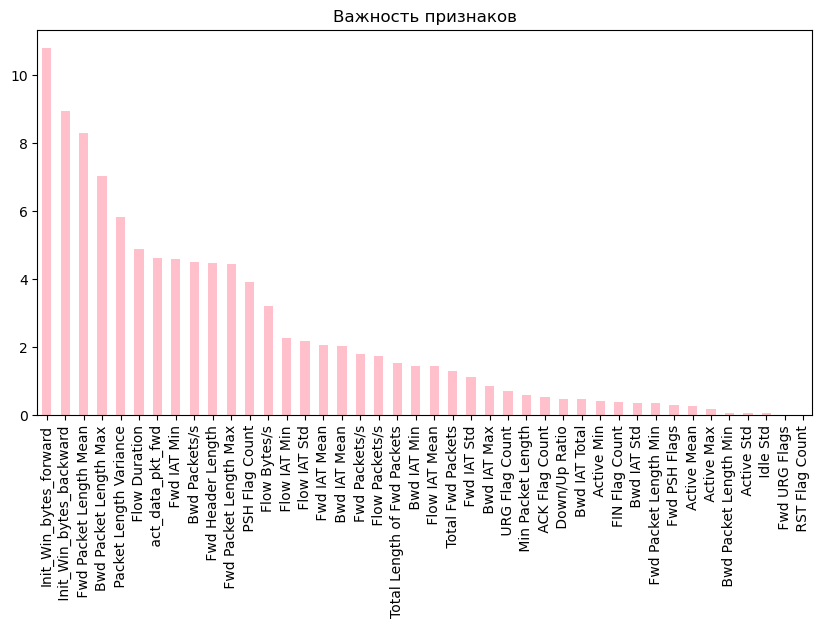

In [97]:
im_df.plot(kind='bar', figsize=(10, 5),
           title='Важность признаков', color='pink', legend=False)
plt.show()

# Вывод
В данном проекте разработана модель, которая классифицирует трафик на нормальный и злонамеренный.  
Для работы использовался датасет размерностью (539616, 78).     

При выполнении проекта была проведена предобработка данных, а именно:  
- удалено 488 пропусков;
- удалено 134617 дубликатов, что состовляет 24% от всех данных.

При разведочном анализе было выявлено, что среди полей присутствуют ; столбцов, заполненных нулями, которые в последствии были удалены. Так же в данных присутствуют 27 признаков, корреляция которых с иными превосходит порог в 0.95. От них тоже пришлось избавиться.   
Данные были разделены на тестовую и тренировочную выборки, для оучения модели был сформирован пайплайн с препроцессором, содержащим функцию для стандартизации численных значений выборки. 
После обучения и тестирования был произведен анализ важности признаков, а также создан REST API сервис, который принимая на вход данные трафика генерирует его класс.

**Итоговая модель:**   

- CatBoostClassifier;
- loss_function: MultiClass;
- eval_metric: Accuracy;
- iterations: 500;
- learning_rate: 0.1. 

**Результаты на тестовой выборке:**  

|                          | precision | recall | f1-score |
|--------------------------|-----------|--------|----------|
| BENIGN                   | 1.00      | 1.00   | 1.00     |
| Bot                      | 0.94      | 0.93   | 0.93     |
| DDoS                     | 1.00      | 1.00   | 1.00     |
| DoS GoldenEye            | 0.99      | 1.00   | 1.00     |
| DoS Hulk                 | 1.00      | 1.00   | 1.00     |
| DoS Slowhttptest         | 0.99      | 0.99   | 0.99     |
| DoS slowloris            | 1.00      | 0.99   | 0.99     |
| FTP-Patator              | 1.00      | 1.00   | 1.00     |
| Heartbleed               | 1.00      | 1.00   | 1.00     |
| Infiltration             | 1.00      | 0.67   | 0.80     |
| PortScan                 | 0.94      | 0.96   | 0.95     |
| SSH-Patator              | 1.00      | 1.00   | 1.00     |
| Web Attack Brute Force   | 0.72      | 0.97   | 0.83     |
| Web Attack Sql Injection | 1.00      | 0.50   | 0.67     |
| Web Attack XSS           | 0.70      | 0.16   | 0.26     |
|||||
| accuracy                 | 1.00      | 1.00   | 1.00     |
| weighted avg             | 1.00      | 1.00   | 1.00     |
| macro avg                | 0.95      | 0.88   | 0.89     |
